In [1]:
from torch import nn
from torch.nn import functional as F
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, sampler
import torchvision.transforms as transforms
import torchvision.datasets as dset
from matplotlib import pyplot as plt
import numpy as np

IMG_SIZE = 28
BATCH_SIZE = 64
EPOCHS = 10
NUM_TRAIN = 49000

In [2]:
# 数据预处理，减去cifar-10数据均值
# The CIFAR10 dataset consists of 32x32 images, which is a relatively small size for modern deep learning models. By resizing the images, we can increase their size and allow the model to extract more features from them. Resizing also helps to reduce the amount of information loss that occurs when we downsample the images to a smaller size.

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# 加载训练集
cifar10_train = dset.CIFAR10(root='./datasets/CIFAR10', train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)


# 加载测试集
cifar10_test = dset.CIFAR10(root='./datasets/CIFAR10', train=False, download=True, transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
image, label = next(iter(DataLoader(cifar10_train, batch_size=18)))
print(image.shape, label.shape)

def get_cifar10_labels(labels):
    text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].permute(1, 2, 0))
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
            axes[i][j].axes.set_title(get_cifar10_labels([label[i * num_cols + j].item()]))
    return axes

# show_images(image, 2, 9, scale=1.4)

torch.Size([18, 3, 224, 224]) torch.Size([18])


In [4]:
# Implement of ResNet 18

class Residual_Block(nn.Module):
    def __init__(self, input_channels, num_channels, 
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                                 kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                                    kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                        kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)
    
# ResNet 18

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual_Block(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual_Block(num_channels, num_channels))
    return nn.Sequential(*blk)

net = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    resnet_block(64, 64, 2, first_block=True),
    resnet_block(64, 128, 2),
    resnet_block(128, 256, 2),
    resnet_block(256, 512, 2),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10)
)




In [16]:
from torchvision.models import resnet18
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('resnet18-10epoch')

# model = resnet18(pretrained=True)
model = net
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader_train, loader_val, criterion, optimizer, epochs=1, print_freq=40):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(loader_train):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if batch_idx % print_freq == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(loader_train.sampler),
                           100. * batch_idx / len(loader_train), loss.item()))
            # print('\nTrain set: Average loss: {:.4f}'.format(total_loss / len(loader_train)))
        writer.add_scalar('loss', total_loss / len(loader_train), epoch)
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in loader_val:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(loader_val.sampler)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(loader_val.sampler),
            100. * correct / len(loader_val.sampler)))
        writer.add_scalar('val_loss', val_loss, epoch)
        writer.add_scalar('val_acc', 100. * correct / len(loader_val.sampler), epoch)
    writer.close()

# train(model, loader_train, loader_test, criterion, optimizer, epochs=10, print_freq=40)

# # 保存模型
# torch.save(model.state_dict(), 'resnet18.pth')

# checkpoint = {'model': net,
#               'state_dict': net.state_dict(),
#               'optimizer' : optimizer.state_dict(),
#               'epoch': 10,}
# torch.save(checkpoint, 'resnet18_checkpoint.pth')


In [17]:
# Continue training

import os

if os.path.exists('resnet18_checkpoint_20.pth'):
    checkpoint = torch.load('resnet18_checkpoint_20.pth')
    net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']
    print('Loaded from checkpoint.')


# train(model, loader_train, loader_test, criterion, optimizer, epochs=20, print_freq=40)


Loaded from checkpoint.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


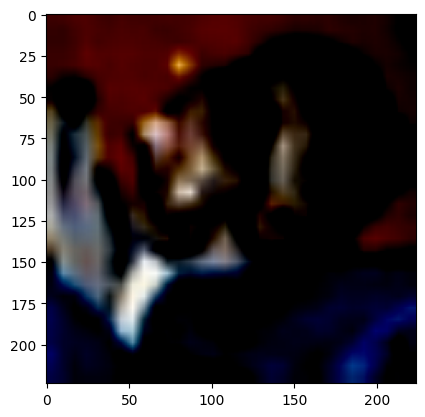

In [20]:
# load model and visualize feature maps

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
checkpoint = torch.load('resnet18_checkpoint_20.pth')

# visualize feature maps
test_img = cifar10_test[0][0].unsqueeze(0).to(device)

plt.imshow(test_img.squeeze().permute(1, 2, 0).cpu())

In [21]:
def print_model_summary(model):
    print(model)
    print("Model Summary:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()}")
            total_params += param.numel()
    print(f"Total Trainable Parameters: {total_params}")

print_model_summary(net)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Residual_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [25]:
# visualize feature maps

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

activation = {}

for idx, module in net._modules.items():
    module.register_forward_hook(get_activation(idx))

output = net(test_img)

torch.Size([64, 56, 56])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])


torch.Size([1, 64, 112, 112])


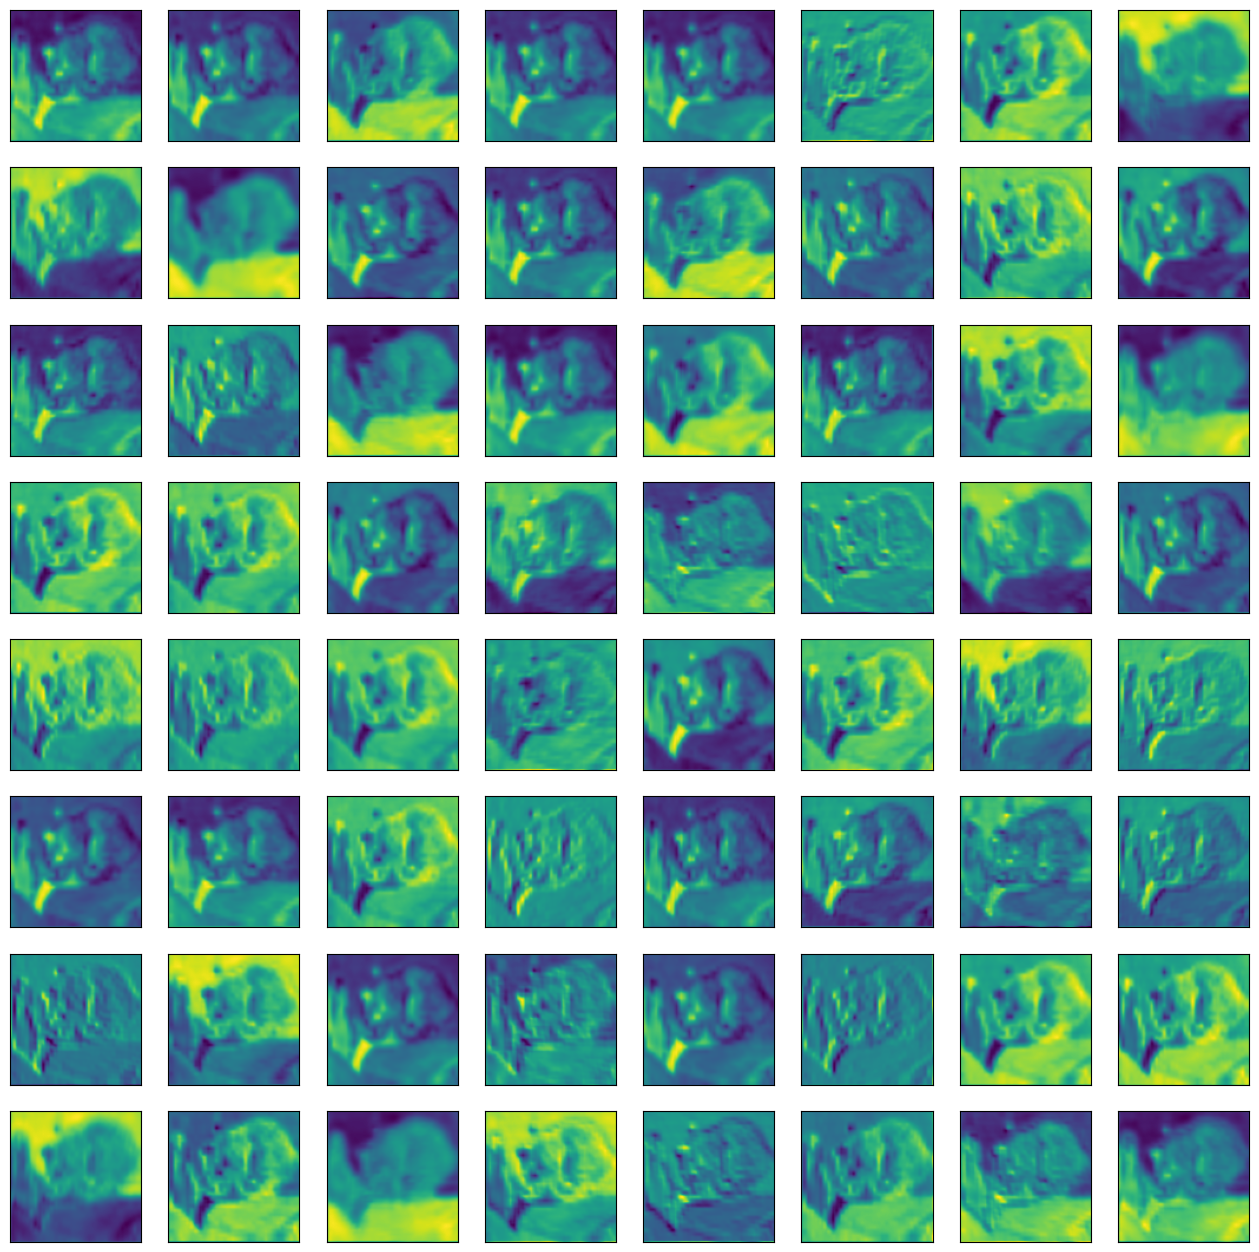

In [28]:
# visualize feature maps
act = activation['0']
print(act.shape)

def show_activation_layer(layer, row=8, col=8, scale=2):
    figsize = (col * scale, row * scale)
    _, axes = plt.subplots(row, col, figsize=figsize)
    for i in range(row):
        for j in range(col):
            axes[i][j].imshow(layer[0][i * col + j].cpu())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    plt.show()


show_activation_layer(act, row=8, col=8, scale=2)

Layer: 1 | Shape: torch.Size([1, 64, 112, 112])


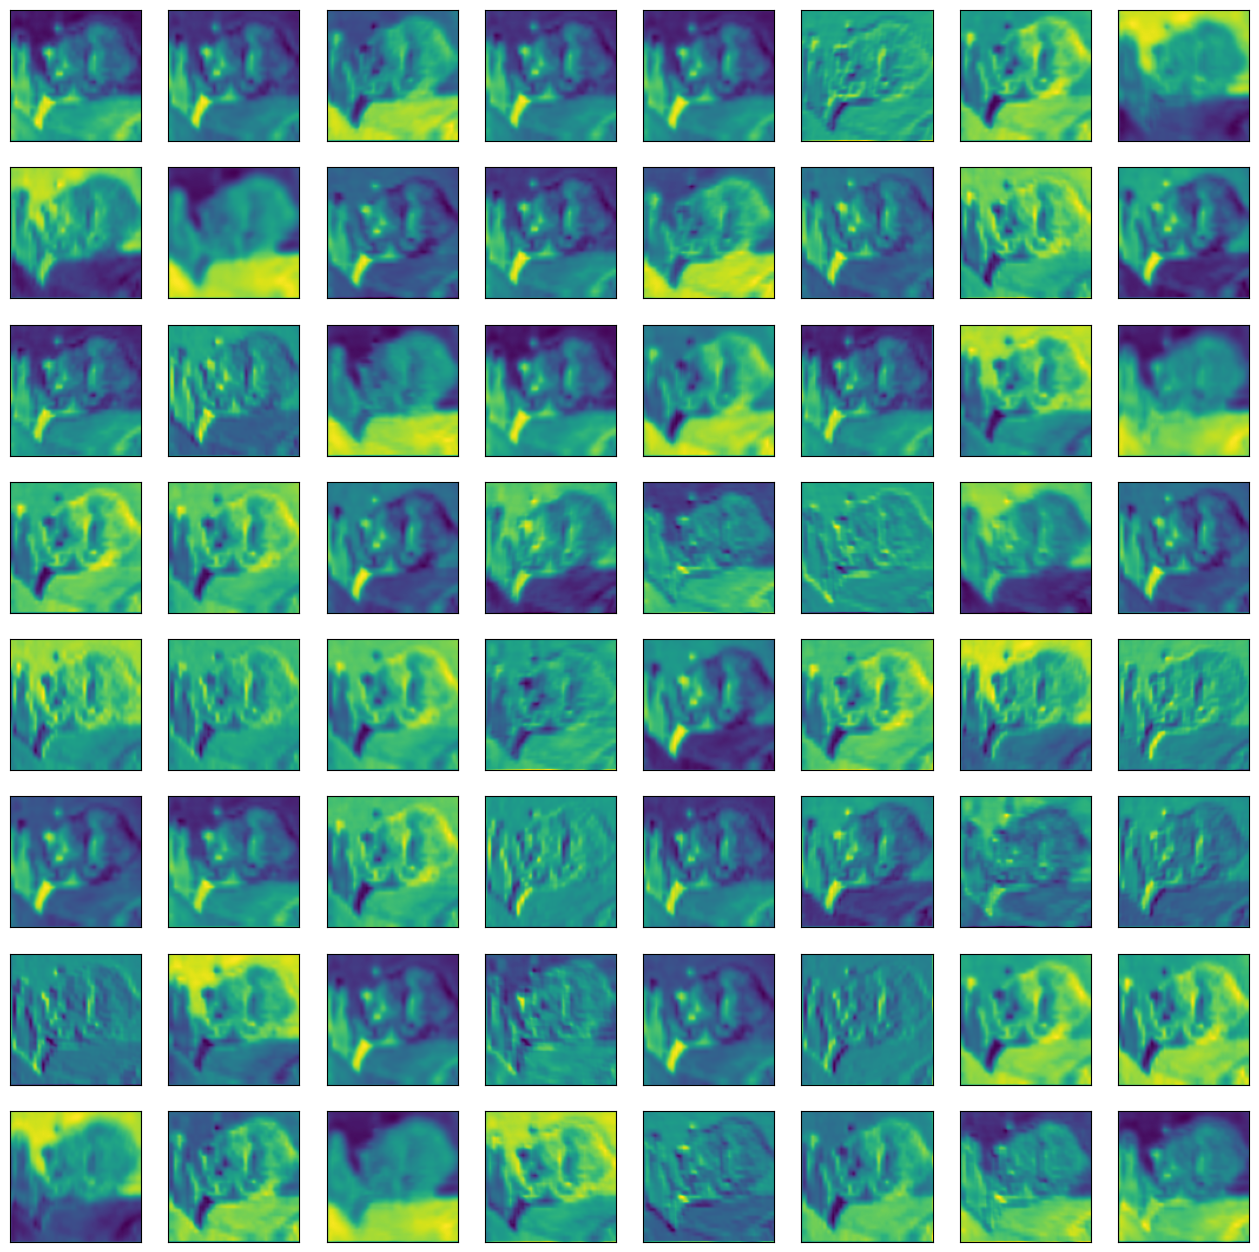

Layer: 2 | Shape: torch.Size([1, 64, 112, 112])


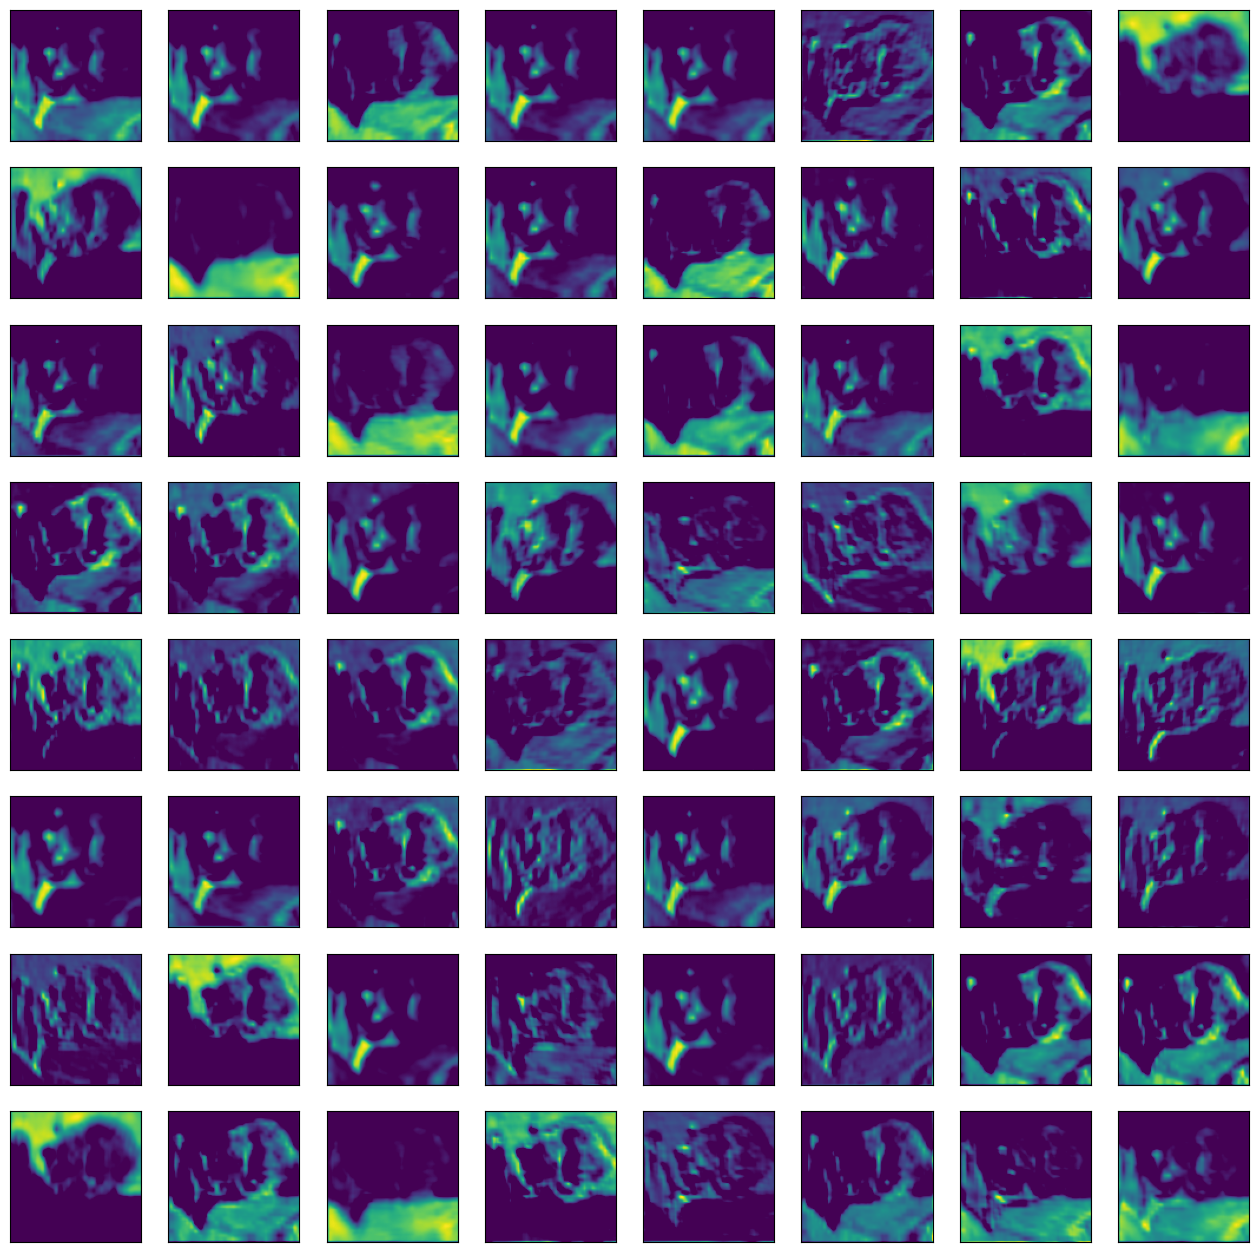

Layer: 3 | Shape: torch.Size([1, 64, 56, 56])


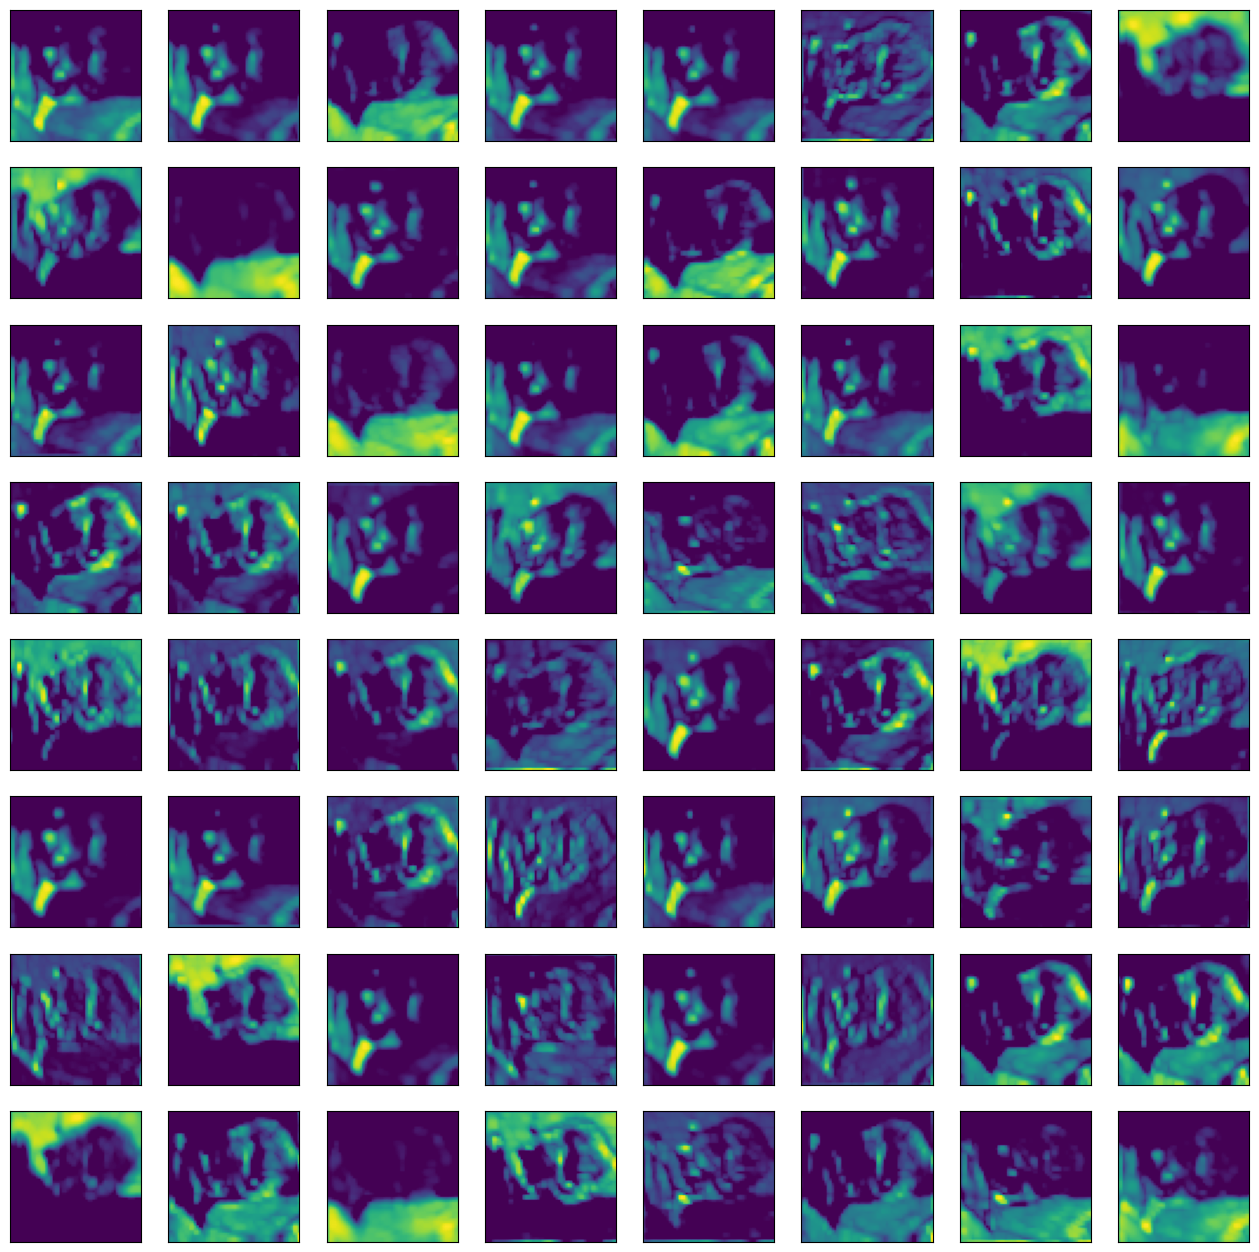

Layer: 4 | Shape: torch.Size([1, 64, 56, 56])


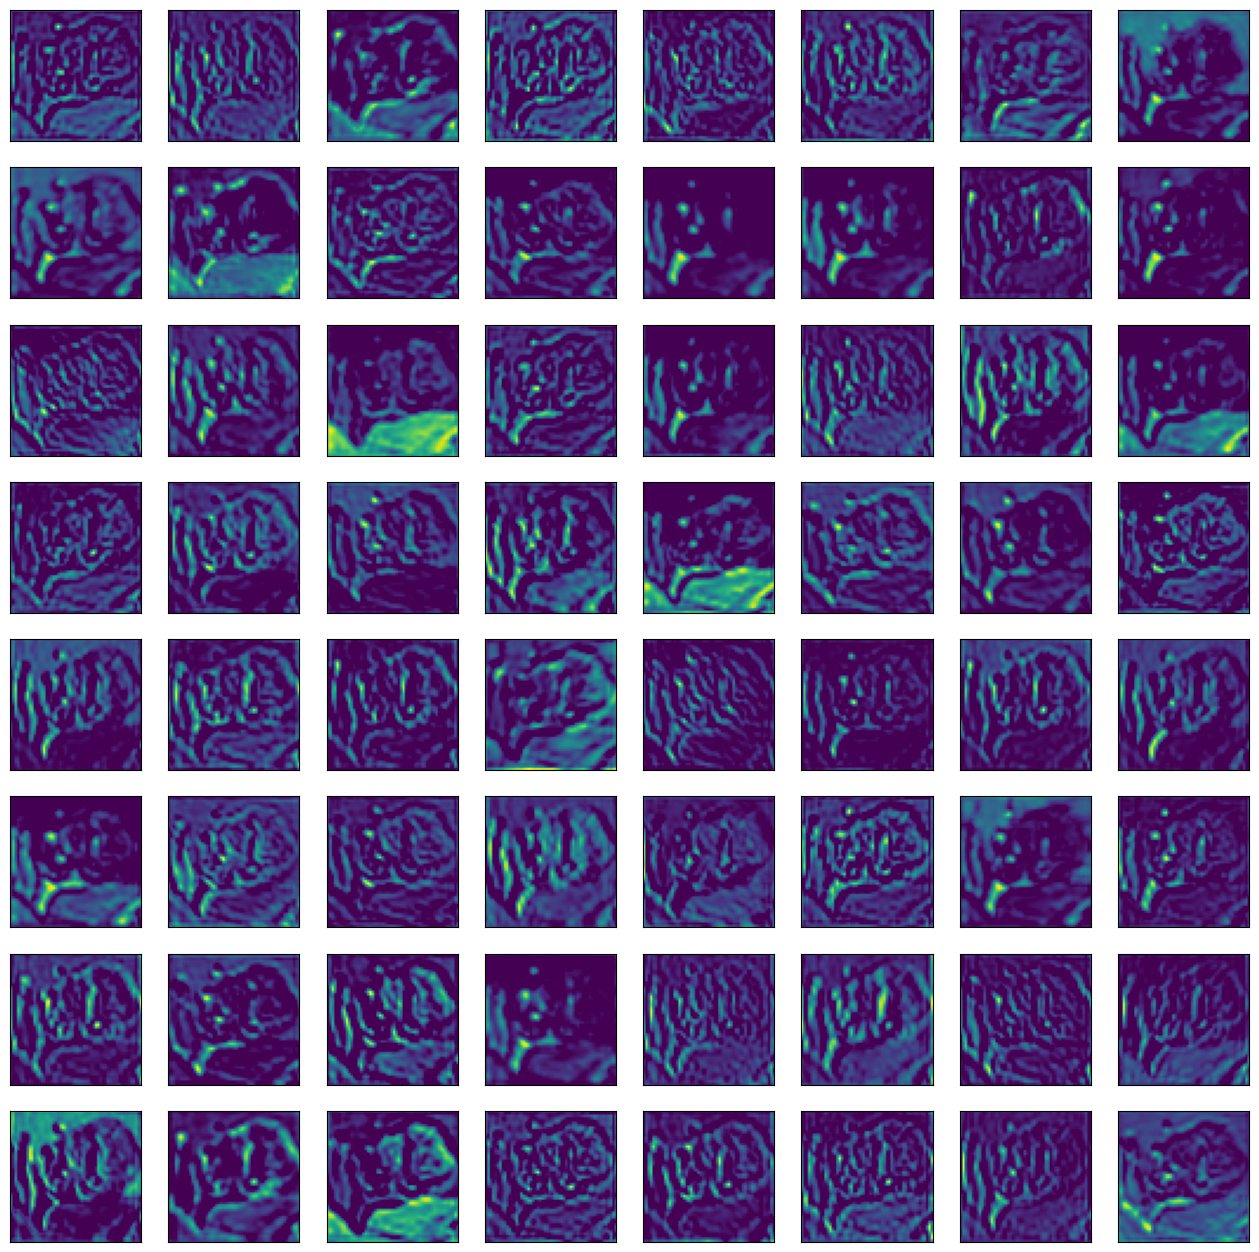

Layer: 5 | Shape: torch.Size([1, 128, 28, 28])


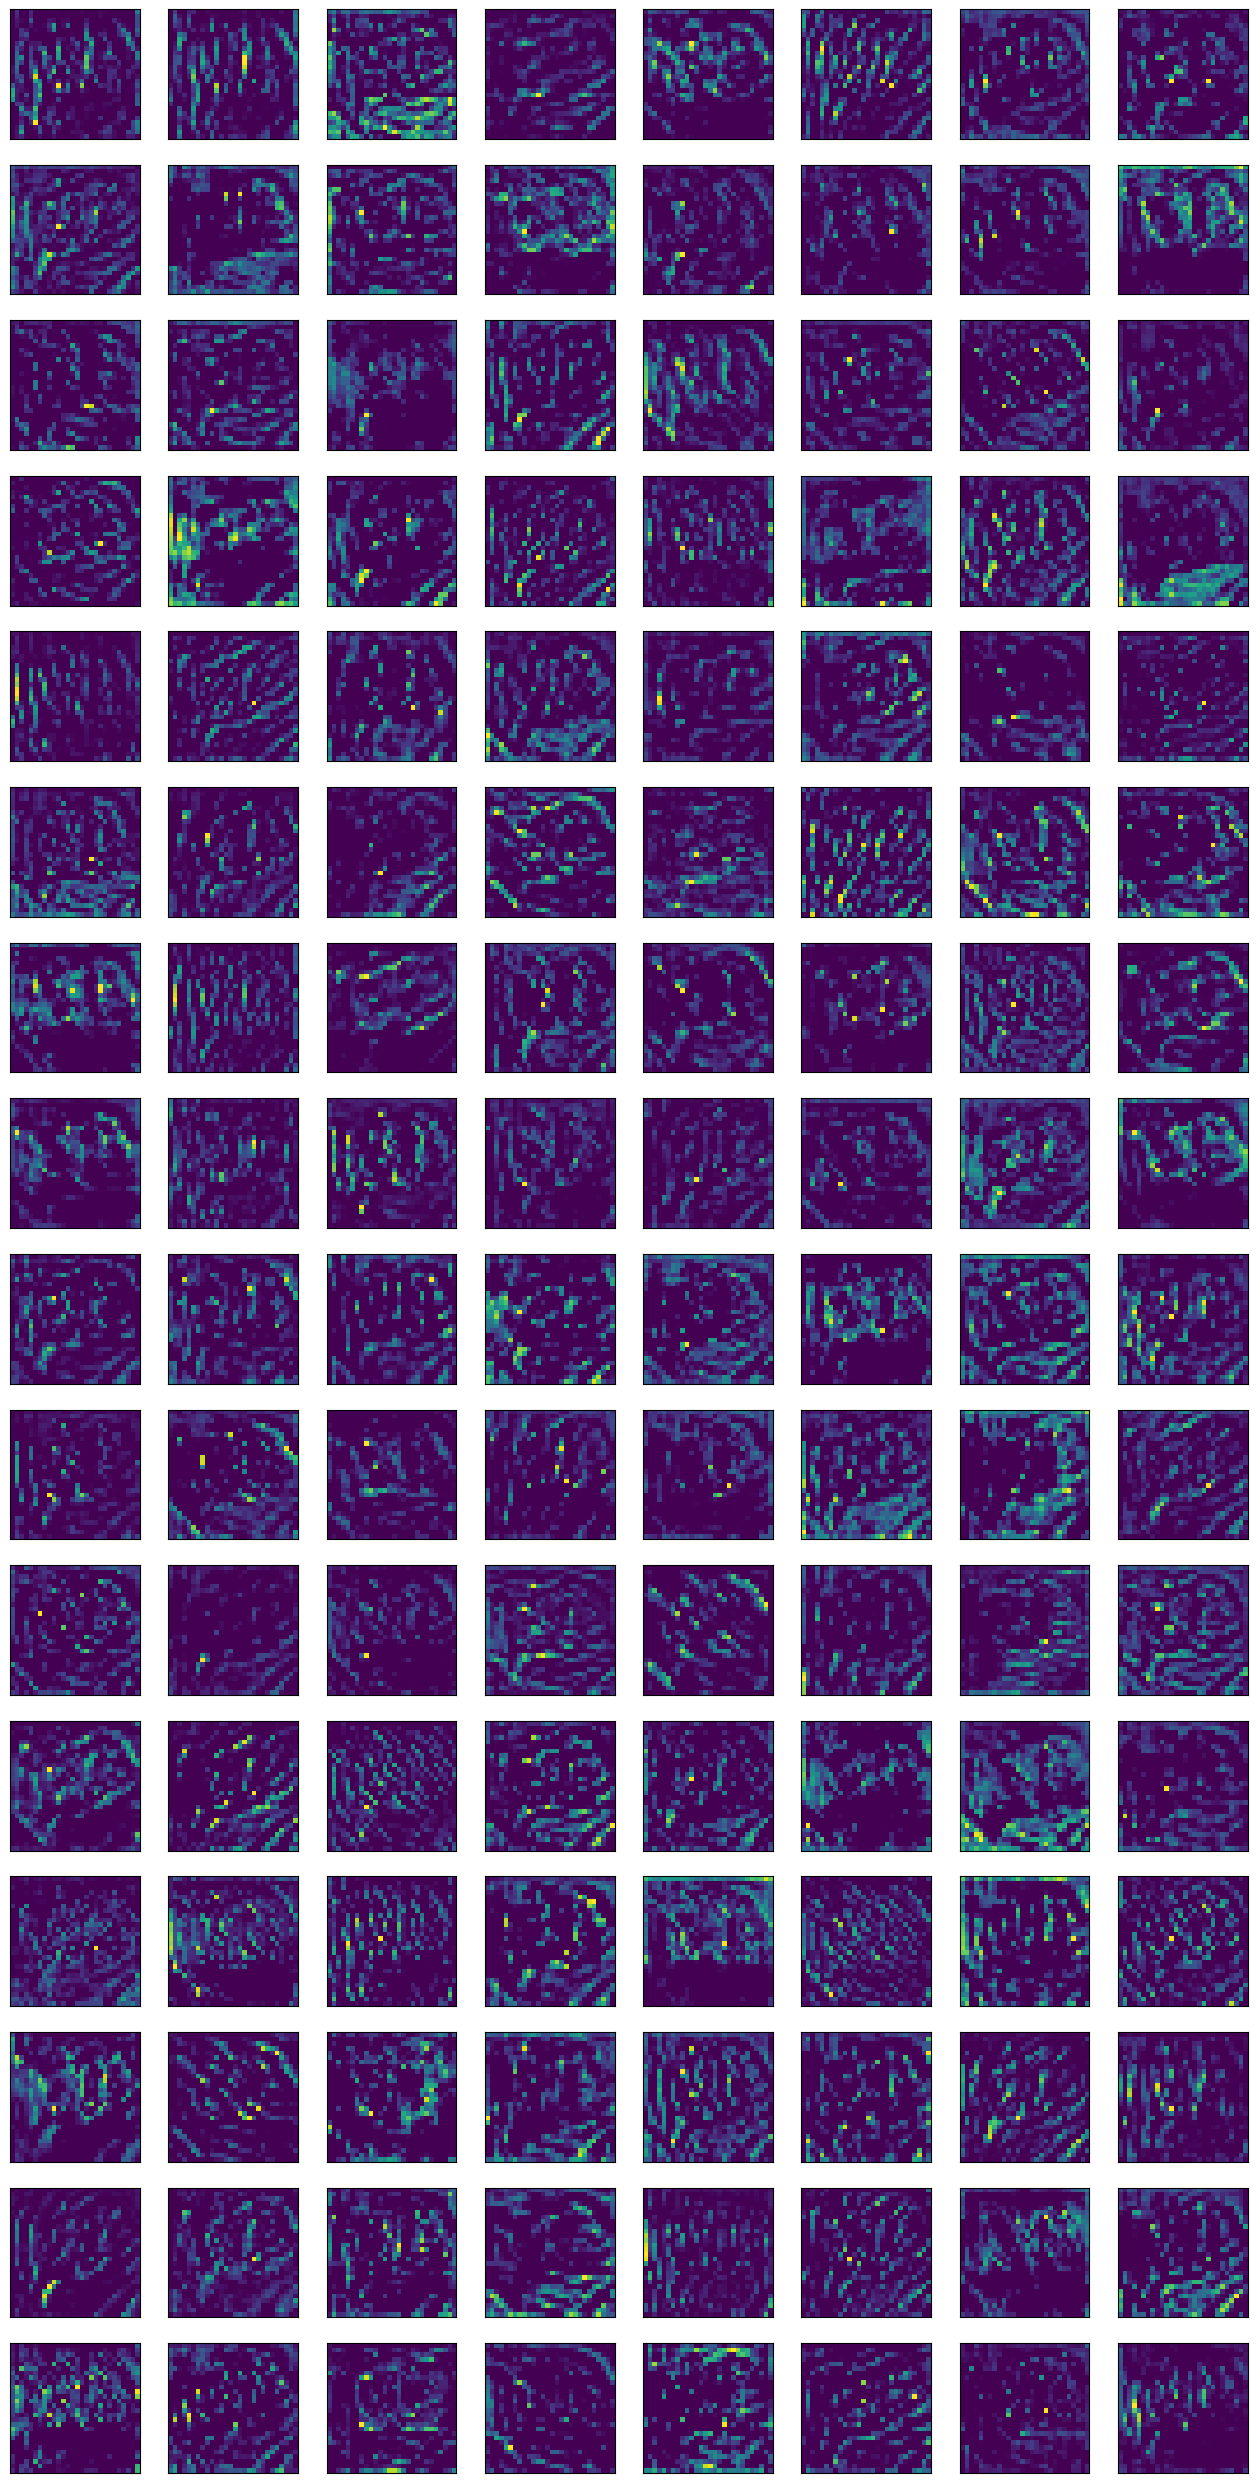

Layer: 6 | Shape: torch.Size([1, 256, 14, 14])


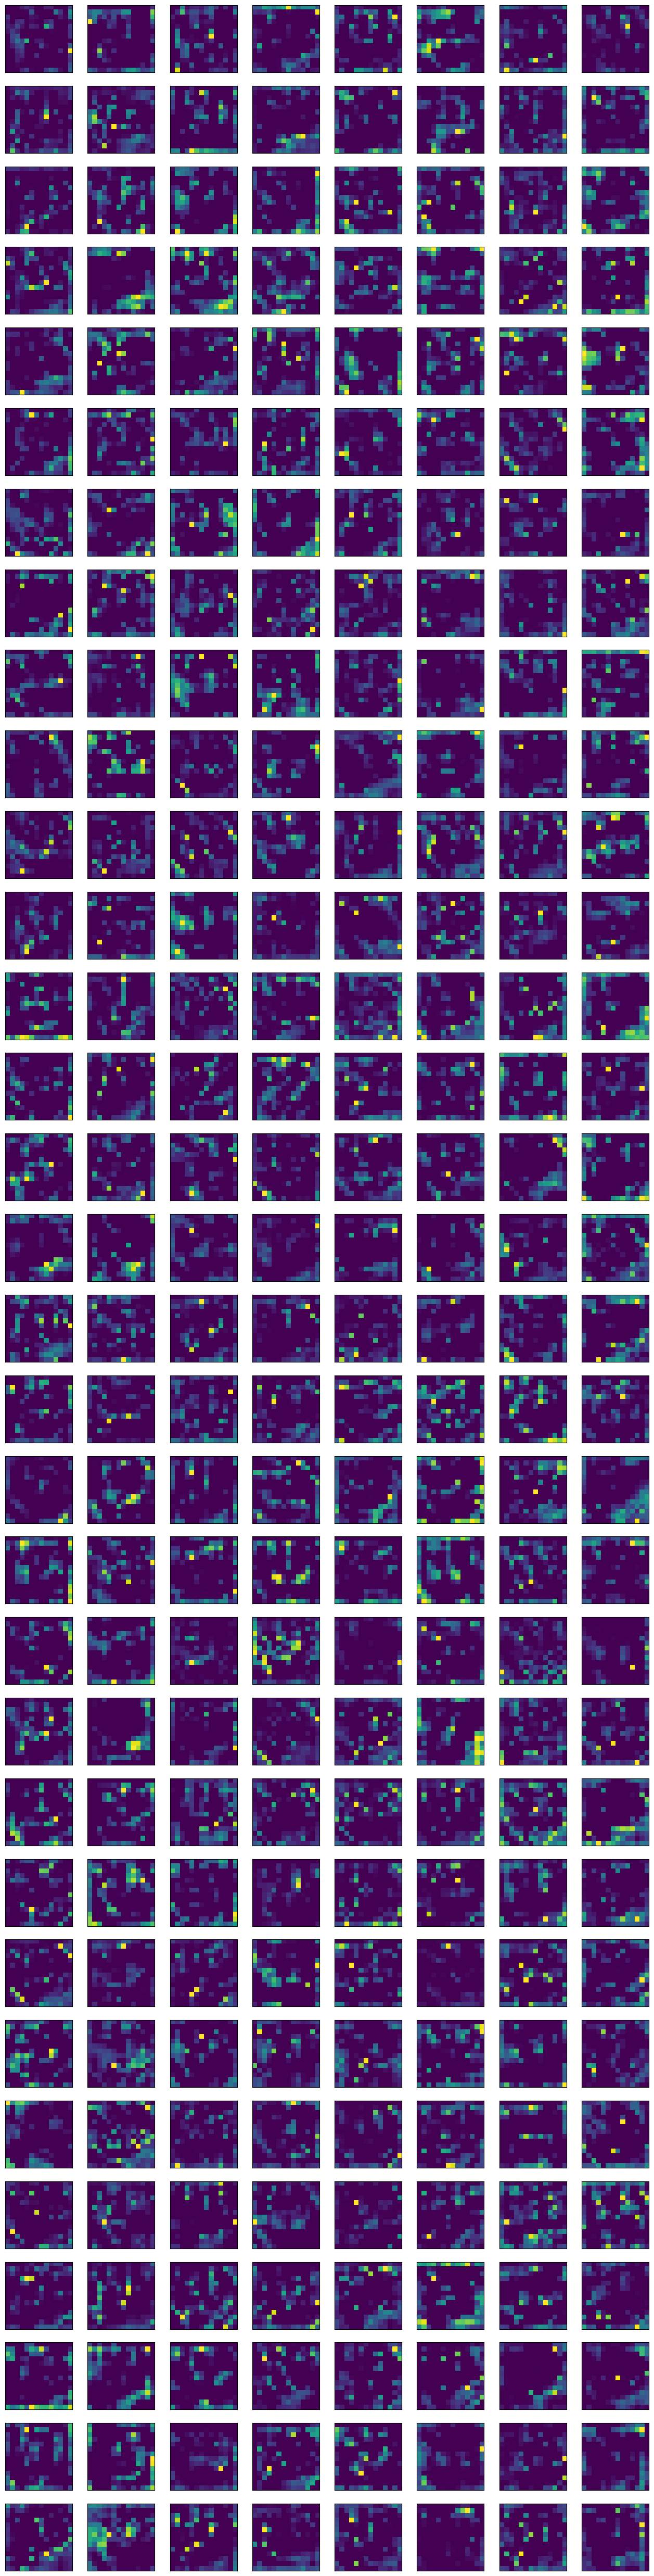

Layer: 7 | Shape: torch.Size([1, 512, 7, 7])


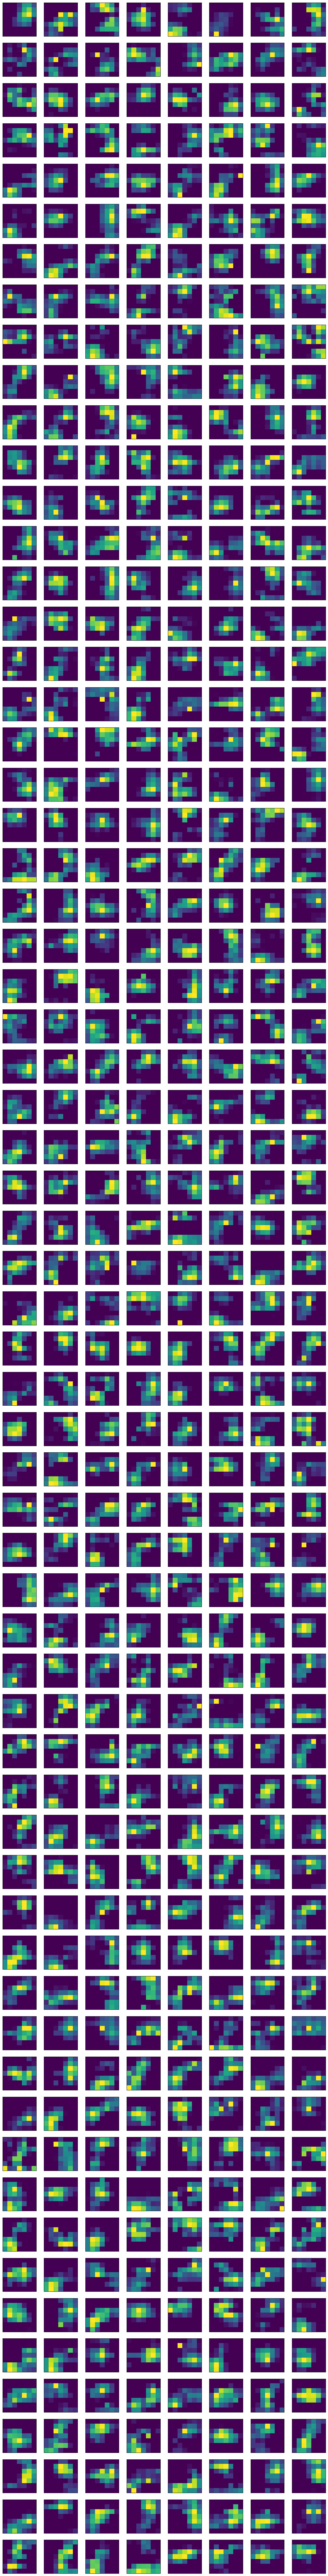

Layer: 8 | Shape: torch.Size([1, 512, 1, 1])


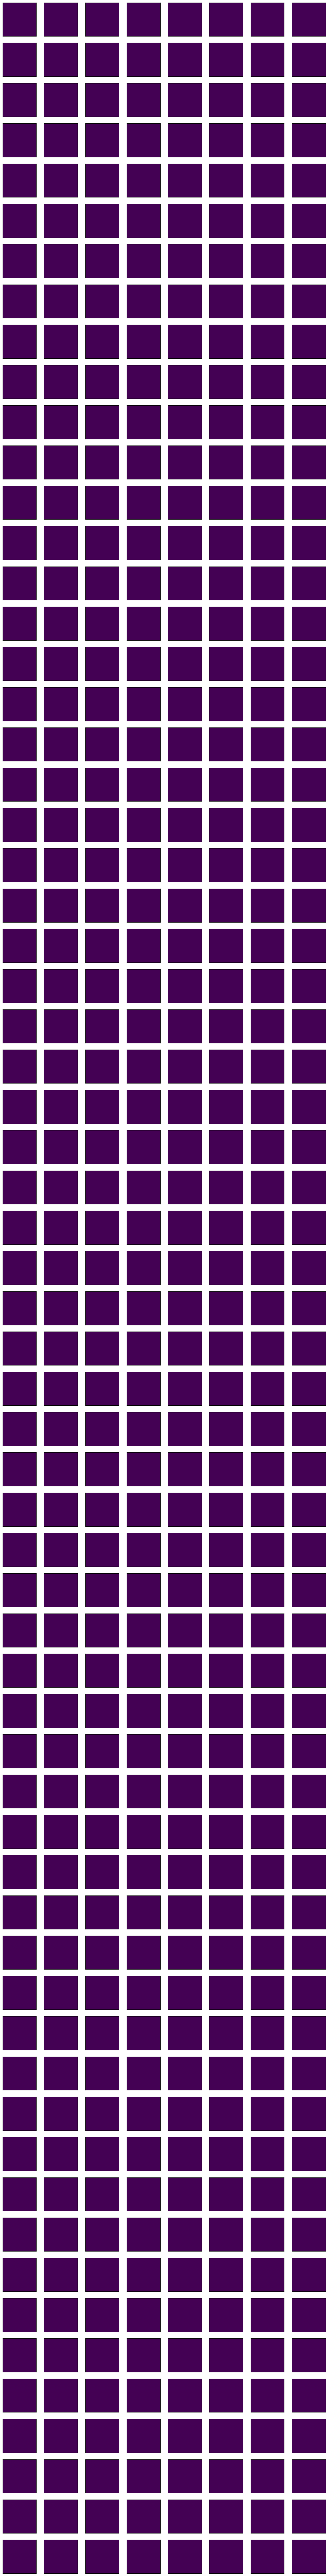

Layer: 9 | Shape: torch.Size([1, 512])


TypeError: Invalid shape () for image data

Error in callback <function _draw_all_if_interactive at 0x000001668AB9F550> (for post_execute):


KeyboardInterrupt: 

In [29]:
for idx, module in net._modules.items():
    if idx == '0':
        continue
    act = activation[idx]
    print(f'Layer: {idx} | Shape: {act.shape}')
    number_rows = act.shape[1] // 8
    show_activation_layer(act, row=number_rows, col=8, scale=2)